Manejo de dataset


In [6]:
# Extraer dataset
import ConstitucionUtil
import re
import random

        

total: 205357

gob_concept 183342
topic: 1 len: 49155
['', 'justicia', 'la justicia no solo relacionada con el derecho penal sino relacionada con la justicia social para todos y todas mayores niveles de igualdad ', 'fact']
['', 'democracia', 'pilar esencial para el diálogo no hay encuentro sin democracia bajo la definición de gobierno del pueblo se subsumen los principios y derechos tales como justicia e igualdad ante la ley separación de poderes derechos humanos libertad entre otros ', 'value']
['', 'respeto conservación de la naturaleza o medio ambiente', 'todos de acuerdo', 'blank']
['', 'democracia', 'derecho a una opinión libre y a votar ', 'fact']
['', 'autonomía libertad', 'se debe asegurar la autodeterminación y el desarrollo individual como a su vez las decisiones populares como un valor que no debe perjudicar a otros ni al entorno la libertad es la capacidad para formar algo diferente del pueblo para generar su autonomía sin afectar a terceros ', 'policy']
topic: 2 len: 46887

Dependiendo del task con el que evaluamos, cambiara como se entrena la red.

Task A: 
 - Separamos el dataset segun topico, y entrenamos distintas redes para cada topico.
 - El dataset se separa en 80% train, 10% dev y 10% test.
 - Eliminamos argumentos que no se relacionen a algun concepto.
 
Task B:
 - Utilizamos modelo entrenado en A
 - Input es el concepto propuesto y concepto propuesto + argumento
 
Task C:
 - Eliminamos argumentos que no se clasifiquen en los modos de argumentacion propuestos

In [2]:
# Extraer embedding

import os
import io
import json

import numpy as np

from scipy.stats import spearmanr
from gensim.models.keyedvectors import KeyedVectors

import Constant
import GlobalTest

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import LongTensor
from torch.nn import Embedding, LSTM
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from ConstitucionUtil import ClassifierModel


# Path a carpeta principal
MAIN_FOLDER = Constant.MAIN_FOLDER

# Path a carpeta con los embeddings
EMBEDDING_FOLDER = Constant.EMBEDDING_FOLDER

# Lista con los nombres de los archivos de los embeddings
embedding_name_list = os.listdir(EMBEDDING_FOLDER)

print(">>> Embeddings a evaluar:")
for embedding in embedding_name_list:
    print("  > " + embedding)

def get_wordvector(file, cant=None):
    print("Cargando embedding " + file)
    wordvector_file = EMBEDDING_FOLDER / file
    word_vector = KeyedVectors.load_word2vec_format(wordvector_file, limit=cant)
    print("Carga lista")
    return word_vector

>>> Embeddings a evaluar:
  > _fasttext_sbwc.vec
  > _fasttext_suc.vec
  > _fasttext_wiki.vec
  > _glove_sbwc.vec
  > _w2v_sbwc.txt


In [2]:
# Crear RNN



In [4]:
# Cargar datasets

def accuracy(prediction, concept):
    #print(prediction.size())
    predict_idx = torch.argmax(prediction, dim=1)
    #print(predict_idx.size())
    #print(concept.size())
    
    sum = 0
    for i in range(len(concept)):
        #print(concept[i])
        #print(predict_idx[i])
        if concept[i] == predict_idx[i]:
            sum += 1
            
    return sum

def line2vecs(word_vector, arguments):
    #print(" > line2vecs")
    tensor = torch.zeros([len(arguments), len(arguments[0])], dtype=torch.long)
    
    for j in range(len(arguments)):
        arg = arguments[j]
        for i in range(len(arg)):
            word = arg[i]
            if word not in word_vector and word != "<pad>":
                print(" word not found: " + word)
                word_vector.add(word, np.random.rand(word_vector.vector_size))
                
            if word == "<pad>":
                tensor[j][i] = 0
            else:
                #t = torch.zeros(1, len(word_vector.vocab))
                #t[0][word_vector.vocab[word].index] = 1
                tensor[j][i] = word_vector.vocab[word].index + 1
            
    return tensor


def getTrainExample(arguments, concepts, concepts_list, word_vector):
    #print(" > get train example")
    # TODO: cambiar por creacion de batch
    argument_vectors = line2vecs(word_vector, arguments)
    concept_vector = torch.tensor([torch.tensor([concepts_list.index(concept)], dtype=torch.long) for concept in concepts])
    
    return argument_vectors, concept_vector


def categoryFromOutput(output, concepts):
    name = []
    id = []
    for i in range(len(output)):
        top_n, top_i = output[i].topk(1)
        category_i = top_i[0].item()
        name.append(concepts[category_i])
        id.append(category_i)
        
    return name, id


criterion = nn.NLLLoss()


def ltmsTrain(concept_tensor, argument_tensor, lstm):
    learning_rate = 0.005
    
    lstm.zero_grad()

    output, hidden = lstm(argument_tensor)
    #print(" > lstm output ", end='')
    #print(output.size())
    #print(" > lstm output[-1] ", end='')
    #print(output[-1].size())
    #print(" > concept_tensor ", end='')
    #print(concept_tensor.size())

    loss = criterion(output[-1], concept_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in lstm.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output[-1], loss.item()


def train(concept_tensor, argument_tensor, rnn):
    learning_rate = 0.005
    
    hidden = rnn.initHidden()
    rnn.zero_grad()

    for i in range(argument_tensor.size()[0]):
        output, hidden = rnn(argument_tensor[i], hidden)
        
    print(output.size())
    print(output[-1].size())
    print(concept_tensor.size())

    loss = criterion(output[-1], concept_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output[-1], loss.item()


def predict(concept_tensor, argument_tensor, rnn):
    for i in range(argument_tensor.size()[0]):
        output, hidden = rnn(argument_tensor[i], hidden)

    loss = criterion(output, concept_tensor)
    return output, loss.item()


def padding(batch):
    pad = "<pad>"
    args = [x[0] for x in batch]
    cons = [x[1] for x in batch]
    
    seq_lengths = list(map(len, args))
    max_lengths = max(seq_lengths)
    for i in range(len(args)):
        args[i] = (args[i] + [pad for i in range(max_lengths - len(args[i]))]) if len(args[i]) < max_lengths else args[i]
        
    return [args, seq_lengths, cons]
    
    


def generateBatch(data, batch_size):
    shuffle(data)
    batches = []
    aux_batch = []
    for pair in data:
        argument = pair[0]
        concept = pair[1]
        
        if argument == []:
            continue
            
        aux_batch.append([argument, concept])
        if len(aux_batch) == batch_size:
            batches.append(aux_batch)
            aux_batch = []
            
    if len(aux_batch) != 0:
        batches.append(aux_batch)
    
    for i in range(len(batches)):
        args, len_seq, cons = padding(batches[i])
        batches[i] = [args, len_seq, cons]
            
    return batches


def getEmbedding(word_vector):
    vocab = []
    for i in range(len(word_vector.index2word)):
        word = word_vector.index2word[i]
        vocab.append(word_vector[word])
    
    vocab = torch.tensor(vocab)
    emb = nn.Embedding.from_pretrained(vocab)
    
    return emb


def cleanDataVocab(data, word_vector, replace_oov=False):
    revised_data = {}
    
    for key in data.keys():
        revised_data[key] = []
        new_pair = []
        
        for pair in data[key]:
            for i in range(len(pair)-1):
                try:
                    l = pair[i].strip().split()
                    r = []
                except:
                    print(pair)
                    raise Exception
                
                for word in l:
                    if word not in word_vector:
                        if replace_oov:
                            word_vector.add(word, np.random.rand(word_vector.vector_size))
                        else:
                            continue
                    
                    r.append(word)
                    
                if len(r) == 0:
                    new_pair = []
                    break
                    
                new_pair.append(r)
                
            if len(new_pair) == 0:
                continue
                
            new_pair.append(pair[-1])
            revised_data[key].append(new_pair)
            
            new_pair = []
        print(key + " " + str(len(revised_data[key])))
            
    return revised_data


In [5]:
import io
from random import shuffle

# Get datasets from files

_DATASET = Constant.DATA_FOLDER / "_Constitucion"

train_task_A = {}
dev_task_A = {}
test_task_A = {}
data_taskB = {}

with io.open(_DATASET / "task_A_train.txt", 'r') as f:
    for line in f:
        tupla = line.strip().split('/')
        topic = tupla[0]
        gob_concept = tupla[1]
        argument = tupla[2]
        
        if topic not in train_task_A:
            train_task_A[topic] = []
            
        train_task_A[topic].append([argument, gob_concept])
            
print("train_task_A")
for topic in train_task_A.keys():
    print(topic + " " + str(len(train_task_A[topic])))
            
            
with io.open(_DATASET / "task_A_dev.txt", 'r') as f:
    for line in f:
        tupla = line.strip().split('/')
        topic = tupla[0]
        gob_concept = tupla[1]
        argument = tupla[2]
        
        if topic not in dev_task_A:
            dev_task_A[topic] = []
            
        dev_task_A[topic].append([argument, gob_concept])
            
print("dev_task_A")
for topic in dev_task_A.keys():
    print(topic + " " + str(len(dev_task_A[topic])))
    
            
with io.open(_DATASET / "task_A_test.txt", 'r') as f:
    for line in f:
        tupla = line.strip().split('/')
        topic = tupla[0]
        gob_concept = tupla[1]
        argument = tupla[2]
        
        if topic not in test_task_A:
            test_task_A[topic] = []
            
        test_task_A[topic].append([argument, gob_concept])
            
print("test_task_A")
for topic in test_task_A.keys():
    print(topic + " " + str(len(test_task_A[topic])))
    
            
with io.open(_DATASET / "task_B_dataset.txt", 'r') as f:
    for line in f:
        tupla = line.strip().split('/')
        topic = tupla[0]
        gob_concept = tupla[1]
        open_concept = tupla[2]
        argument = tupla[3]
        
        if topic not in data_taskB:
            data_taskB[topic] = []
            
        data_taskB[topic].append([argument, open_concept, gob_concept])
            
print("data_taskB")
for topic in data_taskB.keys():
    print(topic + " " + str(len(data_taskB[topic])))
            

train_task_A
1 37508
2 36346
3 33173
4 32780
dev_task_A
1 4690
2 4541
3 4145
4 4097
test_task_A
1 4705
2 4565
3 4154
4 4107
data_taskB
1 1964
2 3356
3 1820
4 3084


In [6]:
# Entrenar RNN
#for embedding_name in embedding_name_list:
embedding_name = embedding_name_list[0]
print("Test de embedding " + embedding_name)

word_vector = get_wordvector(embedding_name, cant=10000)

Test de embedding _fasttext_sbwc.vec
Cargando embedding _fasttext_sbwc.vec
Carga lista


In [6]:

print(torch.version.cuda)
print(torch.cuda.is_available())
print(torch.cuda.current_device())


10.2
True
0


In [7]:
# tamaño de input y hidden layer
n_input = word_vector.vector_size
n_hidden = 128


# Revisar palabras oov
clean_train_task_A = cleanDataVocab(train_task_A, word_vector)
clean_dev_task_A = cleanDataVocab(dev_task_A, word_vector)
clean_test_task_A = cleanDataVocab(test_task_A, word_vector)
#word_vector.add("<pad>", np.random.rand(word_vector.vector_size))
pad = torch.FloatTensor([np.random.rand(word_vector.vector_size)])
for topic in clean_train_task_A.keys():
    print(topic + " " + str(len(clean_train_task_A[topic])) + " " + str(len(train_task_A[topic])))
    
    for i in range(5):
        print(" > ", end='')
        print(clean_train_task_A[topic][i])
        
weight = torch.FloatTensor(word_vector.vectors)
weight = torch.cat([pad, weight])
weight.cuda()
print(weight.size())


# Train set
topic = list(clean_train_task_A.keys())[0]
print("Training topic " + topic)

train_topic = clean_train_task_A[topic]
dev_topic = clean_dev_task_A[topic]
test_topic = clean_test_task_A[topic]
print("amount of pairs: " + str(len(train_topic)) + "\n")


# Define concepts
concept_list = []
for pair in train_topic:
    concept = pair[1]
    if concept not in concept_list:
        concept_list.append(concept)
        
concept_list.sort()
n_output = len(concept_list)
print("num_concept: " + str(n_output))
for c in concept_list:
    print(" > " + c)


# Get RNN
mylstm = ClassifierModel(n_output, weight)
mylstm.cuda()
#mylstm.cuda()
optimizer = torch.optim.Adam(mylstm.parameters())

print(mylstm)
for p in mylstm.parameters():
    print(p)

all_losses = []
epoch = 100
learning_rate = 0.01
batch_size = 1000


1 37442
2 36156
3 33002
4 32615
1 4684
2 4520
3 4125
4 4067
1 4700
2 4535
3 4131
4 4084
1 37442 37508
 > [['la', 'justicia', 'no', 'solo', 'relacionada', 'con', 'el', 'derecho', 'penal', 'sino', 'relacionada', 'con', 'la', 'justicia', 'social', 'para', 'todos', 'y', 'todas', 'mayores', 'niveles', 'de', 'igualdad'], 'justicia']
 > [['todo', 'el', 'funcionamiento', 'del', 'país', 'sus', 'actividades', 'en', 'general', 'deben', 'estar', 'de', 'justicia'], 'justicia']
 > [['que', 'exista', 'igualdad', 'ante', 'todo'], 'justicia']
 > [['justicia', 'no', 'solo', 'en', 'el', 'ámbito', 'jurídico', 'sino', 'a', 'la', 'que', 'a', 'la', 'sociedad', 'lo', 'laboral', 'y', 'oportunidades', 'no', 'más', 'distinción', 'de', 'ningún', 'tipo'], 'justicia']
 > [['el', 'acceso', 'a', 'una', 'igualdad', 'ante', 'la', 'ley', 'debe', 'ser', 'asegurado', 'y', 'con', 'equidad', 'los', 'delitos', 'contra', 'las', 'personas', 'o', 'llamados', 'de', 'cuello', 'y', 'deben', 'tener', 'sanciones'], 'justicia']
2 361

d:\documents\memoria - eval. word embeddings\env\lib\site-packages\torch\nn\modules\rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
for i in range(1, epoch+1):
    print("Epoca: " + str(i))
    
    # Generate batchs
    train_batch = generateBatch(train_topic, batch_size)
    dev_batch = generateBatch(dev_topic, batch_size)
    test_batch = generateBatch(test_topic, batch_size)
    print("Number of batchs: " + str(len(train_batch)))
    
    count = 0
    for b in train_batch:
        count += 1
        print("batch " + str(count))
        
        arg = b[0]
        size = b[1]
        con = b[2]
        
        arg, con = getTrainExample(arg, con, concept_list, word_vector)
        size = torch.tensor(size, dtype=torch.long)
        
        mylstm.zero_grad()
        output = mylstm(arg.cuda(), size.cuda())
        
        loss = criterion(output, con.cuda())
        print(" > loss: ", end='')
        print(loss.item())
        
        correct_pred = accuracy(output, con)
        print(" > accuracy: ", end='')
        print(str(correct_pred) + " / " + str(len(con)), end='\n\n')
        
        loss.backward()
        all_losses.append(loss)
        
        optimizer.step()
        
        if count % 10 == 0:
            arg = dev_batch[0][0]
            size = dev_batch[0][1]
            con = dev_batch[0][2]
            
            arg, con = getTrainExample(arg, con, concept_list, word_vector)
            size = torch.tensor(size, dtype=torch.long)
            
            learning_rate = 0.01
            mylstm.zero_grad()
            
            output = mylstm(arg.cuda(), size.cuda())
            
            print(" >> Comparing with dev")
            
            loss = criterion(output, con.cuda())
            print(" > loss: ", end='')
            print(loss.item())
        
            correct_pred = accuracy(output, con)
            print(" > accuracy: ", end='')
            print(str(correct_pred) + " / " + str(len(con)), end='\n\n')
    

Epoca: 1
Number of batchs: 38
batch 1
 >> forward
 > max_len
tensor(101, device='cuda:0')
 > emb
torch.Size([1000, 101, 300])
 > out(max_len_seq x batch_len x output_size)
torch.Size([1000, 101, 37])
 > out(reshape)
torch.Size([101000, 37])
 > last_out
torch.Size([1000, 37])
 > logits
torch.Size([1000, 37])
 > loss: 3.653965711593628
 > accuracy: 32 / 1000

batch 2
 >> forward
 > max_len
tensor(135, device='cuda:0')
 > emb
torch.Size([1000, 135, 300])
 > out(max_len_seq x batch_len x output_size)
torch.Size([1000, 135, 37])
 > out(reshape)
torch.Size([135000, 37])
 > last_out
torch.Size([1000, 37])
 > logits
torch.Size([1000, 37])
 > loss: 3.644725799560547
 > accuracy: 32 / 1000

batch 3
 >> forward
 > max_len
tensor(162, device='cuda:0')
 > emb
torch.Size([1000, 162, 300])
 > out(max_len_seq x batch_len x output_size)
torch.Size([1000, 162, 37])
 > out(reshape)
torch.Size([162000, 37])
 > last_out
torch.Size([1000, 37])
 > logits
torch.Size([1000, 37])
 > loss: 3.6319103240966797
 > 

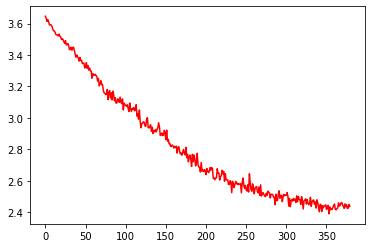

In [13]:
# Testear RNN
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses, 'r')

plt.show()




In [7]:
embedding_name = embedding_name_list[0]
print("Test de embedding " + embedding_name)

word_vector = get_wordvector(embedding_name)

Test de embedding _fasttext_sbwc.vec
Cargando embedding _fasttext_sbwc.vec
Carga lista


In [10]:
import ConstitucionUtil

mean_vec_test = ConstitucionUtil.ConstitucionTestClass()
mean_vec_test.MeanVectorEvaluation(word_vector, embedding_name)


Constitucion test class
Size of dataset: 205357
20000 Que esté presente la libertad de cada individuo, entendiendo esta como la capacidad de ejercer sus derechos sin perjudicar a otros, con autonomía.
oov: 1505
40000 El Estado debe garantizar una convivencia pacífica entre los habitantes de nuestro país como con el resto del mundo.
oov: 2949
60000 Tener el mismo sueldo sin importar de donde vienes, sin importar tu apellido, el sexo u otro origen es un derecho constitucional.  Que una persona gane lo mismo que otra haciendo lo mismo.
oov: 4430
80000 Es parte fundamental de la formación personal y humana. Debe ser digna.
oov: 6000
100000 La vivienda, la educación, una previsión social adecuada, de calidad  y sin distinción; deben ser entre otros, derechos sociales priorizados en la nueva constitución.
oov: 7509
120000 Tener una constitución con un origen democrático a través de un plebiscito, la cual sea conocida y respetada por todos.
oov: 8876
140000 un representante publico no seas co

({'1': [0.1194244014430961, 0.3826254509675303],
  '2': [0.1949539309394644, 0.4648239042452424],
  '3': [0.42452091394877467, 0.7985765616362631],
  '4': [0.15901184655885672, 0.4114798796540053]},
 {'1': [0.6390816871329418, 0.8958889482114255],
  '2': [0.584493670886076, 0.7848101265822784],
  '3': [0.6136498516320474, 0.8367952522255193],
  '4': [0.46465696465696466, 0.8475398475398476]},
 {'m': [0.521342453299855, 1.0]})